# Supervised Learning- Classification

In [44]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import mode
from sklearn.model_selection import train_test_split

## Naive Bayes

### Overview

We implement Naive Bayes by following Bayes theorem.
<br>
Bayes Theorem:
$$
    P(A/B) = {P(B/A) * P(A) \over P(B)}
$$
Here,<br>
$A$ => The target variable <br>
$B$ => The attributes <br>
So, the theorem effectively becomes
<br>
$$
    P(y/x_1, x_2, ...x_n) = {P(x_1/y)P(x_2/y)...P(x_n/y)*P(y) \over P(x_1)P(x_2)...P(x_n)}
$$
But since we only need to compare the probability values for the target variables, we can ignore the denominator, and so the final equation is:<br>
$$
    P(y/x_1, x_2, ...x_n) = {P(x_1/y)P(x_2/y)...P(x_n/y)*P(y)}
$$
After finding the probablity of each target variable given all the attributes, we will normalize them to 1, and then compare both.

### Implementation

In [3]:
class NaiveBayesClassifier:
    """
    A classification algorithm that uses the Bayes Theorem to make predictions.
    Assumes independence among predictors, and is paramterized.
    """

    def __init__ (self):
        """
        Constructor does not take any arguments and initializes instance variables.
        # Instance Variables
        
        target_probabilities -> Stores individual probabilities of all unique targets
        attr_probabilities -> Stores conditional probabilities of all unique attributes given unique targets.
        predictions -> Stores the predictions in a list
        """
        self.target_probabilities = {}
        self.attr_probabilities = {}
    
    def fit(self, x_train, y_train):
        """
        This method trains the algorithm on the provided training data.
        It works by extracting information and organizing it in a way such that it is most convenient to use necessary features to apply
        Bayes Theorem. It calculates the probability of all target values, and the conditional probability of all attributes given a target
        value for each target value. These can then be used by the predict method for computation.

        # Parameters

        x_train: Data of all attributes to be trained on
        y_train: Data of label
        """
        df = x_train.copy()
        df['target'] = y_train
        target_count = y_train.value_counts().to_dict()
        for target, count in target_count.items():
            self.target_probabilities[target] = count / y_train.size
        
        for column in x_train.columns:
            attr_unique = x_train[column].unique()
            for attr in attr_unique:
                self.attr_probabilities[(column, attr)] = {}
                for target in self.target_probabilities.keys():
                    temp_df = df[df[column] == attr]
                    temp_df = temp_df[temp_df['target'] == target]
                    self.attr_probabilities[(column, attr)][target] = len(temp_df.index) / target_count[target]

    def predict(self, x_test):
        """
        This method predicts labels by using Bayes Theorem. It uses information condensed by the fit method, in particular the probabilities of all
        target values, and the conditional probabilities of all attributes given a target value, for each target value.

        # Parameters
        
        x_test: Data of attributes for which target is to be predicted
        """
        predictions = []
        target_test_prob = {}
        mult = 1.0
        for index, row in x_test.iterrows():
            for target in self.target_probabilities:
                mult = 1.0
                for column in x_test.columns:
                    attr = row[column]
                    if (column, attr) in self.attr_probabilities:
                        if self.attr_probabilities[(column, attr)][target] == 0:
                            # if the probability of a particular attribute is 0, then it could mean that
                            # we either have not enough data, or the ground truth is absolutely 0. In any case,
                            # assigning a very low probability of 0.0001 should tackle both of these situations.
                            mult *= 0.0001
                        else:
                            mult *= self.attr_probabilities[(column, attr)][target]

                mult *= self.target_probabilities[target]
                target_test_prob[target] = mult
            # Normalize
            target_total_prob = sum(list(target_test_prob.values()))
            for target in target_test_prob:
                target_test_prob[target] = target_test_prob[target] / target_total_prob
            # Add to predictions
            predictions.append(max(target_test_prob, key = lambda x: target_test_prob[x]))
        self.predictions = predictions
    
    def accuracy(self, y_test):
        """Gives the accuracy of the predictions"""
        return np.sum(self.predictions == y_test) / len(y_test)

## K-Nearest Neighbor

### Overview

K-Nearest Neghbors (KNN) is a machine learning classification algorithm. It assumes that similar things exist in close proximity. In other words, the class of a new point is determined by majority of 'k' nearest points. This algorithm is known as a 'lazy' algorithm, because it does do any calculations in its training phase, instead just stores the dataset. The algorithm is non-parametrized as it does not make any assumptions about the data.

### Implementation

In [4]:
def e_distance(x1, x2):
    try:
        return np.sqrt(np.sum((x1 - x2)**2))
    except TypeError:
        print(f"x1 = {x1}\nx2 = {x2}")
        sys.exit()

In [40]:
class knnClassifier:
    
    def __init__(self, k = 3):
        self.k = k

    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        """This method makes predictions based on k nearest neighbors."""
        y_pred = []
        for point in x_test.to_numpy():
            distances = []
            for i in range(len(self.x_train)):
                distances.append(e_distance(np.array(self.x_train.iloc[i]), point))
            distance_data = pd.DataFrame(data = distances, columns = ['distance'], index = self.y_train.index)
            k_neighbors = distance_data.sort_values(by=['distance'], axis=0)[:self.k]
            labels = self.y_train.loc[k_neighbors.index]
            voting = mode(labels).mode[0]
            y_pred.append(voting)
        
        self.predictions = y_pred
        return y_pred

    def accuracy(self, y_test):
        """Gives the accuracy of the predictions"""
        return np.sum(self.predictions == y_test) / len(y_test)
            

## Titanic Exercise

In [6]:
df = pd.read_csv('./titanic/train.csv')
df_test = pd.read_csv('./titanic/test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Preprocessing

Firstly, we can notice that a person's name, and ticket should not have any relationship to whether someone survived or not. Therefore, these attributes will not be of any use going further.

Now, we can try and see any correlation between all attributes that have numeric, or ordinal values.

In [7]:
num_ord_df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)

In [8]:
corr_matrix = num_ord_df.corr()
print(corr_matrix['Survived'])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64


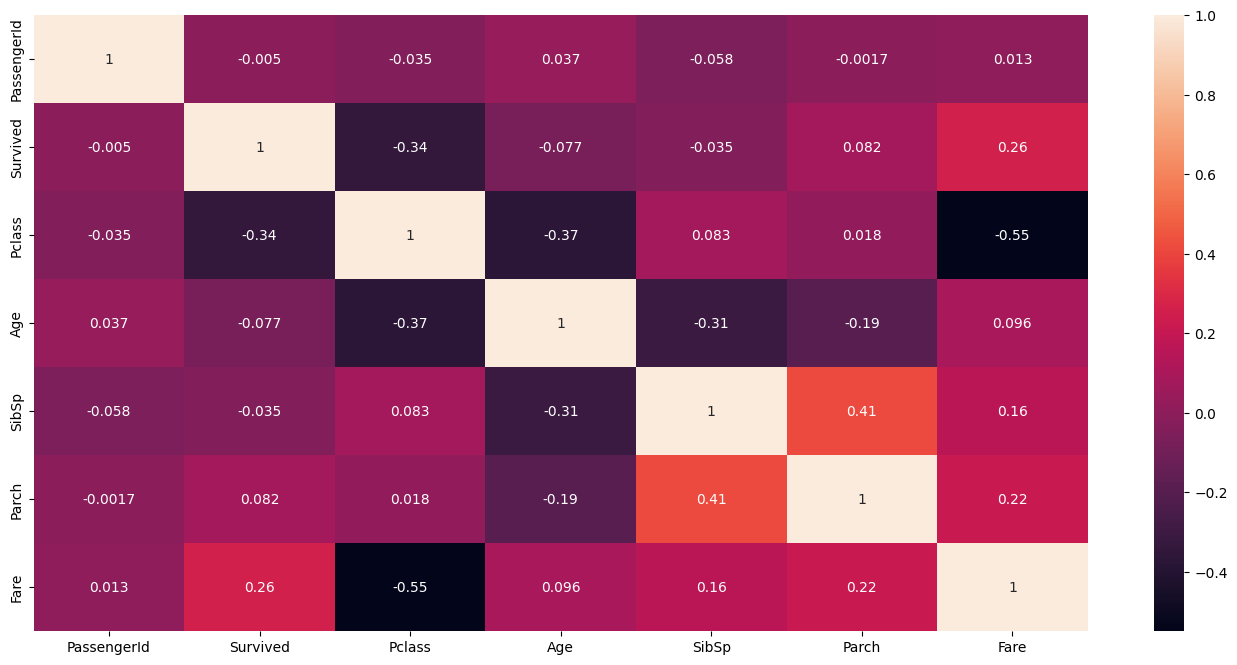

In [9]:
plt.figure(figsize=(17, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

We will arbitrarily choose 5% as the minimum correlation percentage to consider an attribute. So, the only numerical/ordinal attributes that we need to consider are Pclass, Age, Parch, and Fare.

Now, we can try and see any correlation between categorical attributes and whether a person survived or not.

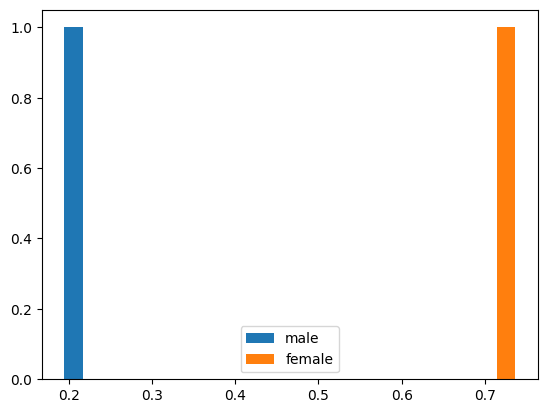

In [10]:
male_female_count_df = df['Sex'].value_counts().reset_index()
male_count = male_female_count_df['count'].loc[male_female_count_df['Sex'] == 'male']
female_count = male_female_count_df['count'].loc[male_female_count_df['Sex'] == 'female']
male_survived = len(df.loc[(df['Sex'] == 'male') & (df['Survived'] == 1)].index) / male_count
female_survived = len(df.loc[(df['Sex'] == 'female') & (df['Survived'] == 1)].index) / female_count
plt.hist([male_survived, female_survived], label=['male', 'female']);
plt.legend()
plt.show();

Here, we see that there is a high discrepancy between survival of man as compared to a woman. Therefore, 'Sex' will be useful attribute going forward.

In [11]:
embarked_count_df = df['Embarked'].value_counts().reset_index()
embarked_count_df.head()

,Embarked,count
0,S,644
1,C,168
2,Q,77


#### Dropping irrelevant columns

As determined above, we can drop the columns 'Name', 'Ticket', 'PassengerId', and 'SibSp.'

In [12]:
df.drop(['Name', 'Ticket', 'PassengerId', 'SibSp'], axis=1, inplace=True)
df_test.drop(['Name', 'Ticket', 'PassengerId', 'SibSp'], axis=1, inplace=True)

Here, we see that there is a high relation between the attribute 'Embarked' and whether a person survived or not. Therefore, this will also be a useful attribute going forward.

In [13]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
df_test.isnull().sum()

Pclass        0
Sex           0
Age          86
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

Since the cabin column has a lot of missing values, we can simply drop it.
As for the columns 'Age' and 'Embarked', we can fill them in with the median values.
<br>
For the test data, we can fill in the missing Fare value with the fare median.

In [15]:
df.drop(['Cabin'], axis=1, inplace=True)
df_test.drop(['Cabin'], axis=1, inplace=True)

In [16]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Since the most frequent value for 'Embarked' is 'S', we can fill in the missing values with the same.

In [17]:
df['Embarked'] = df['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

#### One-hot encoding

In [18]:
for temp in [df, df_test]:
    temp.loc[(temp['Sex'] == "male"), 'Sex'] = 1
    temp.loc[(temp['Sex'] == "female"), 'Sex'] = 2
    temp['Sex'] = temp['Sex'].astype(int)

In [19]:
for temp in [df, df_test]:
    temp.loc[(temp['Embarked'] == "C"), 'Embarked'] = 1
    temp.loc[(temp['Embarked'] == "Q"), 'Embarked'] = 2
    temp.loc[(temp['Embarked'] == "S"), 'Embarked'] = 3
    temp['Embarked'] = temp['Embarked'].astype(int)

In [20]:
print(f"min age = {df['Age'].min()}\nmax age = {df['Age'].max()}")
print(f"min fare = {df['Fare'].min()}\nmax fare = {df['Fare'].max()}")

min age = 0.42
max age = 80.0
min fare = 0.0
max fare = 512.3292


In [21]:
for temp in [df, df_test]:
    temp.loc[(temp['Age'] > 0) & (temp['Age'] <= 20), 'Age'] = 1
    temp.loc[(temp['Age'] > 20) & (temp['Age'] <= 40), 'Age'] = 2
    temp.loc[(temp['Age'] > 40) & (temp['Age'] <= 60), 'Age'] = 3
    temp.loc[(temp['Age'] > 60) & (temp['Age'] <= 80), 'Age'] = 4
    temp['Age'] = temp['Age'].astype(int)

In [22]:
for temp in [df, df_test]:
    temp.loc[(temp['Fare'] >= 0) & (temp['Fare'] <= 100), 'Fare'] = 1
    temp.loc[(temp['Fare'] > 100) & (temp['Fare'] <= 200), 'Fare'] = 2
    temp.loc[(temp['Fare'] > 200) & (temp['Fare'] <= 300), 'Fare'] = 3
    temp.loc[(temp['Fare'] > 300) & (temp['Fare'] <= 400), 'Fare'] = 4
    temp.loc[(temp['Fare'] > 400) & (temp['Fare'] <= 500), 'Fare'] = 5
    temp.loc[(temp['Fare'] > 500) & (temp['Fare'] <= 600), 'Fare'] = 6
    temp['Fare'] = temp['Fare'].astype(int)
    # for fare in temp['Fare']:

In [23]:
print(df.head())
print(df_test.head())

   Survived  Pclass  Sex  Age  Parch  Fare  Embarked
0         0       3    1    2      0     1         3
1         1       1    2    2      0     1         1
2         1       3    2    2      0     1         3
3         1       1    2    2      0     1         3
4         0       3    1    2      0     1         3
   Pclass  Sex  Age  Parch  Fare  Embarked
0       3    1    2      0     1         2
1       3    2    3      0     1         3
2       2    1    4      0     1         2
3       3    1    2      0     1         3
4       3    2    2      1     1         3


Now, we are ready to train and test our models.

In [24]:
y = df['Survived']
X = df.drop(['Survived'], axis=1)

#### Splitting the data into train and test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 0)

In [28]:
naive_bayes = NaiveBayesClassifier()
naive_bayes.fit(X_train, y_train)

In [29]:
naive_bayes.predict(X_test)

In [30]:
naive_bayes.accuracy(y_test)

0.8222222222222222

In [41]:
knn = knnClassifier()
knn.fit(X_train, y_train)

In [42]:
knn.predict(X_test);

/tmp/ipykernel_12531/859722739.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  voting = mode(labels).mode[0]


In [43]:
knn.accuracy(y_test)

0.7777777777777778